## 1. Definizione Imports

In [1]:
# Roba generica
import numpy as np
from pathlib import Path

# Gestione dataframe
import pandas as pd

# Per grafici e gestione delle immagini
import cv2 as cv
import matplotlib.pyplot as plt

# Pytorch
import torch

# Barre che mostrano il progresso
from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
# Se uso colab (e dunque dovrò collegarmi a drive)
_COLAB_IN_USE = True
# (Lasciare a True nella prima esecuzione) Scarica dataset ed aggiorna librerie
_FIRST_INIT = False

In [3]:
# Se uso il drive lo monto
if _COLAB_IN_USE:
  from google.colab import drive
  import sys

  drive.mount("/content/drive/")
  base_path = Path('/content/drive/My Drive/Tesi Magistrale Informatica/')
  base_libraries_path = Path('/content/drive/My Drive/Tesi Magistrale Informatica/MultiClass-Classification/')
  sys.path.append(str(base_libraries_path))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Per colab, aggiornamento delle librerie

In [4]:
# Da eseguire una singola volta per essere sicuri che le librerie siano presenti aggiornate
if _COLAB_IN_USE and _FIRST_INIT:
  !pip install albumentations --upgrade
  !pip install efficientnet_pytorch

#### Import del modello e delle funzioni per utilizzarlo

In [5]:
# Modello della rete e funzioni
import JDModel
# Modello personalizzato della nostra rete neurale
from JDModel import ConcreteModel
# Funzioni utili per l'uso della rete
import JDUtils

## 2. Definizione Variabili

### Definizione Variabili Generiche

In [6]:
#----- VARIABILE PER IL PERCORSO DEL DATASET -----
#path per le immagini da classificare
DS_PATH = Path('/content/drive/My Drive/Tesi Magistrale Informatica/Dataset/ToClassify/')
#------------------------------------------------
#path per il percorso in cui andrò a caricare i parametri del modello
#le estensioni standard sono .pt e .pth
MODEL_SAVE_PATH= base_libraries_path/'2classes_Model_Params.pt'
#------------------------------------------------

#----- VARIABILE PER I PLOT -----
#dimensioni delle immagini
#altezza
plots_height = 20
#larghezza
plots_width = 20

# Decidere se usare le nostre stats o quelle di imagenet
# Se Falso usiamo le nostre
# Se True usiamo quelle di imagenet
USE_IMAGENET_STATS = False

#PRINT VALORE VARIABILI
print("----- Paths -----")
print("Path Dataset To Classify:", str(DS_PATH))
print("Path Model Params:", str(MODEL_SAVE_PATH))
print("\n----- Dataset Stats -----")
print("Use Imagenet Stats: " + str(USE_IMAGENET_STATS))

----- Paths -----
Path Dataset To Classify: /content/drive/My Drive/Tesi Magistrale Informatica/Dataset/ToClassify
Path Model Params: /content/drive/My Drive/Tesi Magistrale Informatica/MultiClass-Classification/2classes_Model_Params.pt

----- Dataset Stats -----
Use Imagenet Stats: False


### Definizione Variabili della Rete

In [7]:
# BATCH SIZE, SE SI HA PIù RAM, SI PUò AUMENTARE PER VELOCIZZARE, ALTRIMENTI SI PUò RIDURRE SE SI HA POCA RAM
# Default: 64
batch_size = 128
BS = batch_size
OC = 2
# Flag per uso deterministico della rete (si può ricreare lo stesso risultato eseguendo più volte il notebook)
deterministic_behaviour = False;

# Nome della rete EfficientNet da utilizzare
network_model_name = JDUtils.getModelName()

## 3. Caricamento della Rete

In [8]:
# Inizializzo il random
rseed = JDUtils.init_random(deterministic_behaviour = deterministic_behaviour)

# Costruisco il modello di base della rete
model = JDModel.ConcreteModel(model_name = network_model_name, n_classes = OC)
# Carico il valore dei parametri
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
# Prendo il device in uso
device = JDModel.get_device()
model = model.to(device)
# Imposto il modello in eval (e non in training)
model.eval()
print("Model Loaded")

Loaded pretrained weights for efficientnet-b3
----- ConcreteModel ----
New Classifier Stats: 
Input features 1° Linear:  1536
Input features 2° Linear:  768
Input features 3° Linear:  256
Output 3° Linear:  2
------------------------
Model Loaded


## 4. Lettura immagini e Predizione

### Preparazione Dati e Trasformazioni

In [9]:
# Carico il Dataset
data_to_predict = [o for o in DS_PATH.iterdir()]
data_dimension = len(data_to_predict)
#-------------------------------------------------------
# PER IL TEST CON 2 CLASSI (normal e crack)
mean = np.array([0.64235782, 0.67521094, 0.6952953])
std = np.array([0.12726447, 0.12827764, 0.13181914])
#-------------------------------------------------------

# Mi prendo l'input size atteso della rete -> (width, height, channels)
input_image_size = JDUtils.getModelInputSize()
input_width = input_image_size[0]
input_height = input_image_size[1]
# Stats normalizzate del nostro dataset
dataset_normalized_stats = {'mean':mean, 'std':std}
# SE SI VUOLE USARE LE STATS DI IMAGENET SOVRASCRIVO LA SCELTA
if USE_IMAGENET_STATS:
  dataset_normalized_stats = imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}

test_tfms = JDUtils.get_validation_tfms(dataset_normalized_stats)

print("Normalization stats usate -> Mean: " + str(dataset_normalized_stats['mean']) + " | STD: " + str(dataset_normalized_stats['std']))
print("Input Image dimension:", input_image_size)
print("Image to classify:", data_dimension)

Normalization stats usate -> Mean: [0.64235782 0.67521094 0.6952953 ] | STD: [0.12726447 0.12827764 0.13181914]
Input Image dimension: (227, 227, 3)
Image to classify: 4


### Metodi per segmentare e predirre le immagini

In [10]:
def prepare_crops(input_image_path, width = 227, height = 227, batch_size = 32, img_tfms = None):
    # Leggo l'immagine, la parte finale serve x la traduzione dei colori, altrimenti rimane tutta bluastra
    img = cv.imread(str(input_image_path))
    imgheight, imgwidth, imgchannels = img.shape
    
    # Preparo le sub_images
    sub_imgs = []
    # Eseguo i tagli all'immagine, per avere sub-images di dimensione corretta per la rete
    for i in range(0, imgheight, height):
      for j in range(0, imgwidth, width):
        subimg = img[i:i+height, j:j+width]
        sub_imgs.append(subimg)
    # Prendo numero di immagini trovate
    n_subimgs = len(sub_imgs)
    # Prendo il dataloader
    sub_imgs_dl = JDUtils.get_valid_dataloader(sub_imgs, data_transformations = img_tfms, dl_bs = batch_size, num_dl_workers = 4)
    return img, sub_imgs_dl, n_subimgs

def predict_on_crops(model, input_dl, dl_size, batch_size = 32):
    # Predizione delle sub-images
    # Creo la progressbar
    data_table = master_bar(range(dl_size))
    # Risultati delle predizioni
    results = np.zeros(dl_size)
    # Classifico le sub-images in base al batch_size
    with torch.no_grad():
      device = JDModel.get_device()
      for i, (xb, indexes) in enumerate(progress_bar(input_dl)):
        bs, output = JDModel.test_step(xb, model, device)
        # SE IL DATALOADER NON ESEGUE SHUFFLE POSSO FARE QUESTO
        results[i*bs : i*bs+bs] = output
        # SE IL DATALOADER ESEGUE SHUFFLE I RISULTATI DIPENDONO DA indexes
        #QUESTO DOVREBBE FUNZIONARE COME IL FOR MA è + PERFORMANTE
        #results[indexes] = output
        #for j, (index) in enumerate(indexes):
          #results[index] = output[j]
    #print(results)
    return results

def show_predictions(input_image, results, width = 227, height = 227):
  # Contiene la colorazione delle sub-images in base alla loro classificazione del modello
  output_image = np.zeros_like(input_image)
  imgheight, imgwidth, imgchannels = img.shape
  cont = 0
  for i in range(0, imgheight, height):
    for j in range(0, imgwidth, width):
      # Sub-image di riferimento
      subimg = input_image[i:i+height, j:j+width]
      # Classificazione fatta per la sub-image
      predicted_class = results[cont]
      merge_img = subimg
      # Se ho predetto qualcosa di diverso da 'normale'
      if predicted_class > 0:
        #Crepa -> VERDE
        color = (0, 255, 0)
        # Creo un layer della dimensione della sub-image
        classification_layer = np.zeros_like(subimg, dtype = np.uint8)
        # Coloro interamente il layer del colore definito dalla classificazione
        classification_layer[:] = color
        # Definisco la merge_img come il merge fra la subimg e il nuovo layer dando priorità alla subimg
        # (Il colore deve giusto essere una trasparenza colorata)
        merge_img = cv.addWeighted(subimg, 0.7, classification_layer, 0.3, 0)

      # Imposto la sezione dell'immagine di output con la merge_img
      output_image[i:i+height, j:j+width] = merge_img
      # Passo alla prossima subimg
      cont += 1
  # Ritorno l'immagine di output contenente per ogni subimg la sua classificazione colorata se non è 'normale'
  return output_image

### Stampo a schermo le immagini con le predizioni

Legenda:
Quadrato Verde: Rottura


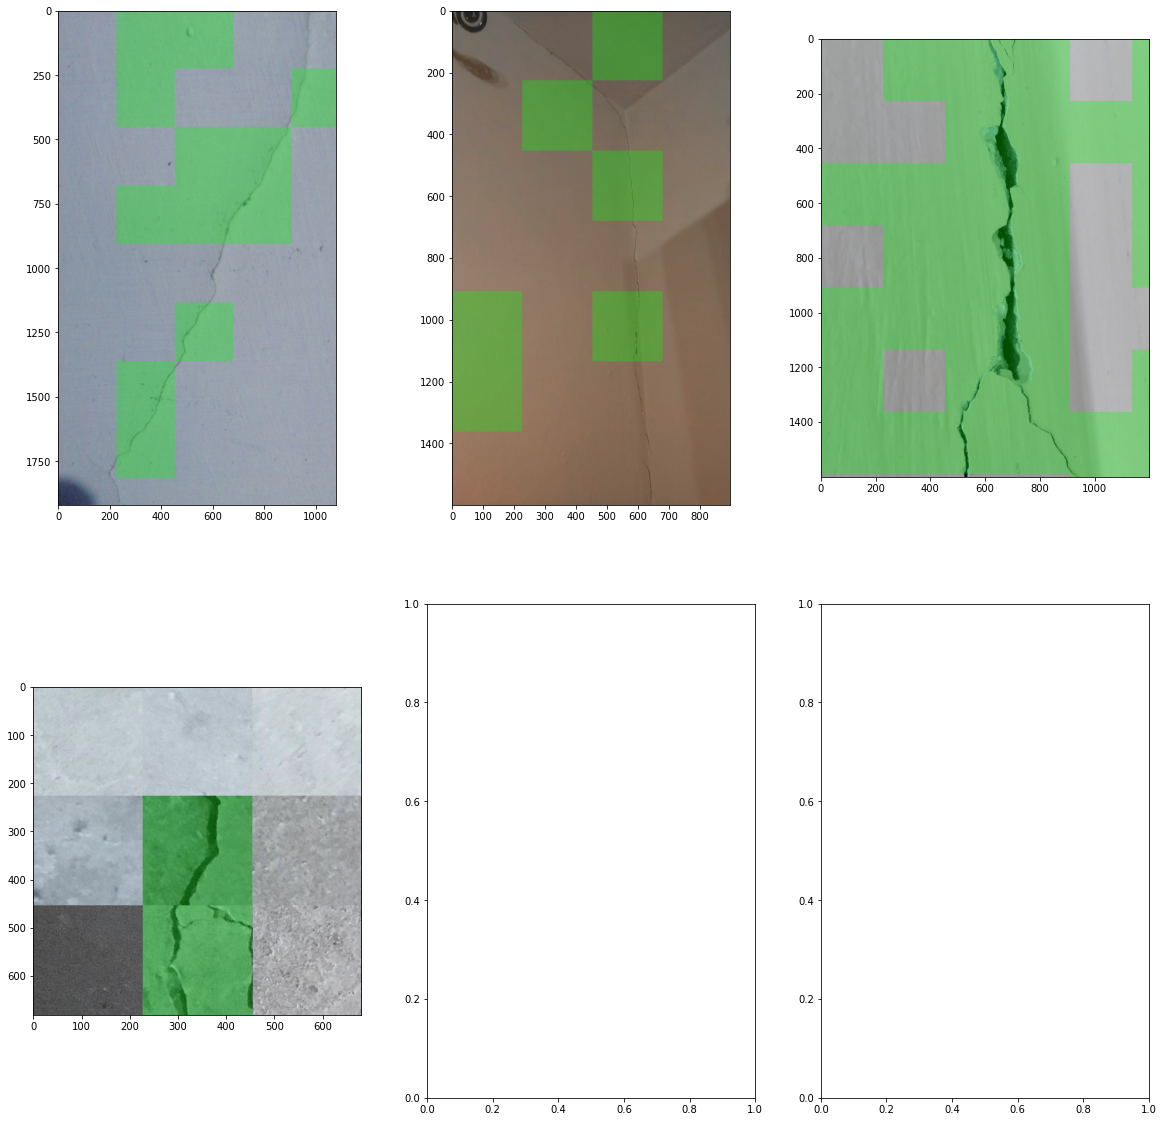

In [14]:
# Imposto le info sul numero di plots da mostrare
N_ROWS = 2 # Deve essere > 1
N_COLUMNS = 3 # Deve essere > 1
N_IMAGES_TO_PLOT = N_ROWS * N_COLUMNS
#SE SONO DI PIù VENGONO CMQ SOLO DISEGNATE N_IMAGES_TO_PLOT
    
fig,a = plt.subplots(N_ROWS, N_COLUMNS)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)

print("Legenda:")
print("Quadrato Verde: Rottura")
# Faccio partire per ogni immagine la predizione e la stampo a schermo
i = j = 0
cont = 0
for img_path in data_to_predict:
  img, sub_imgs_dl, n_subimgs = prepare_crops(img_path, width = input_width, height = input_height, batch_size = BS, img_tfms = test_tfms)
  classification_results = predict_on_crops(model, sub_imgs_dl, n_subimgs, batch_size = BS)
  output_image = show_predictions(img, classification_results, width = input_width, height = input_height)
  if cont < N_IMAGES_TO_PLOT:
    a[i][j].imshow(output_image)
    j += 1
    if j == N_COLUMNS:
      j = 0
      i += 1
    #End-If
  #End-If
  cont += 1